# Applications of Gradient Boosting

This notebook requires `hep_ml`. If you're not using cloud, use 
```
!pip install hep_ml
```

## Reweighting of distributions with Boosted Decision Trees

Initially you have two distributions: sample_original, sample_target. 

You need to reweight a distribution, that is assign new weights to the original distribution so that there is no difference between sample_original (with new weights) and sample_target.

 - reweighting in physics (correction of Monte Carlo simulation)
 - reweighting in surveying (correction for non-response bias)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
import root_numpy
import pandas

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

## Load the data
Dataset is anonymized, so no names of features.
In HEP terms, an original distibution is simulation, a target distribution is Real Data


In [3]:
original = pandas.DataFrame(root_numpy.root2array('datasets/original.root'))
target   = pandas.DataFrame(root_numpy.root2array('datasets/target.root'))

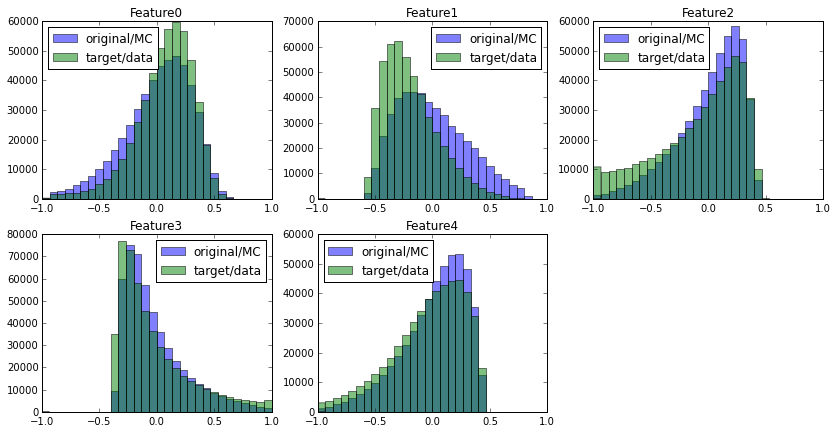

In [5]:
plt.figure(figsize=[14, 7])
for i, column in enumerate(original.columns, start=1):
    plt.subplot(2, 3, i)
    plt.title(column)
    plt.hist(original[column], range=[-1, 1], bins=30, alpha=0.5, label='original/MC')
    plt.hist(target[column],   range=[-1, 1], bins=30, alpha=0.5, label='target/data')
    plt.legend(loc='best')

## Comparison of multidimensional distributions

When you need to say, whether two samples have the same distribution, you have the options:

- simple and wrong: look at 1-dimensional distributions
- good and complex: find out, whether a classification model is able to find the difference between two distributions. <br />
  As usual, we train on the part of the data and then check the quality on a holdout. Let's see:

In [6]:
train_original, test_original = train_test_split(original, train_size=0.4, random_state=42)
train_target,   test_target   = train_test_split(target, train_size=0.4, random_state=42)

In [7]:
# using the default parameters, 
# BUT in practice you should take parameters of classification model used in your analysis
clf = GradientBoostingClassifier()
trainX = numpy.vstack([train_original, train_target])
trainY = [0] * len(train_original) + [1] * len(train_target)
clf.fit(trainX, trainY)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [8]:
testX = numpy.vstack([test_original, test_target])
testY = [0] * len(test_original) + [1] * len(test_target)
test_proba = clf.predict_proba(testX)
train_proba = clf.predict_proba(trainX)

## Checking the discrimination using ROC

pay attention - we used train/test splitting. We see that there is a large difference between the distributions, and a classification model easily found it:

ROC AUC 0.745808225922


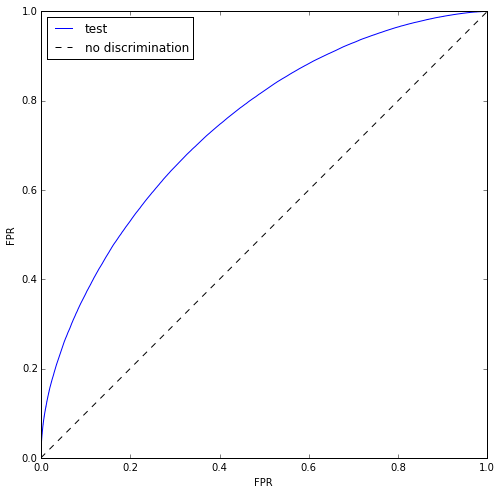

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(testY,  test_proba[:, 1])[:2],  label='test')
plt.plot([0, 1], [0, 1], 'k--', label='no discrimination')
plt.xlabel('FPR'), plt.ylabel('FPR')
plt.legend(loc='best')

print 'ROC AUC', roc_auc_score(testY,  test_proba[:, 1])

## Function for minimal testing of reweighing

In [12]:
# we prepared a special function for testing reweighting
# it plots 1d feature distributions for reweighted original samples and target samples 
#    and roc curve (how a classifier can distinguish reweighted original samples and target samples)
# pay attention - you should use train_original, train_target to train a reweighter 
def check_discrimination(new_test_original_weights):
    new_test_original_weights = numpy.array(new_test_original_weights)
    new_test_original_weights /= 1. * numpy.mean(new_test_original_weights)
    plt.figure(figsize=[14, 7])
    for i, column in enumerate(original.columns, start=1):
        plt.subplot(2, 3, i)
        plt.title(column)
        plt.hist(test_original[column], range=[-1, 1], bins=30, alpha=0.5, normed=True,
                 weights=new_test_original_weights, label='original/MC')
        plt.hist(test_target[column],   range=[-1, 1], bins=30, alpha=0.5, normed=True, label='target/data')
        plt.legend(loc='best')
    plt.show()

    X = numpy.vstack([test_original, test_target])
    y = [0] * len(test_original) + [1] * len(test_target)
    sample_weights = numpy.concatenate((new_test_original_weights, [1] * len(test_target)))
    
    trainX, testX, trainY, testY, trainW, testW = train_test_split(X, y, sample_weights, train_size=0.45, random_state=42)
    
    # using only 30 trees for speed 
    clf = GradientBoostingClassifier(n_estimators=30, random_state=42)
    clf.fit(trainX, trainY, sample_weight=trainW)
    test_proba = clf.predict_proba(testX)
    
    plt.figure(figsize=[8, 8])
    plt.plot(*roc_curve(testY,  test_proba[:, 1], sample_weight=testW)[:2], label='test')
    print 'ROC AUC', roc_auc_score(testY,  test_proba[:, 1], sample_weight=testW)
    plt.plot([0, 1], [0, 1], 'k--', label='no discrimination')
    plt.xlabel('FPR'), plt.ylabel('FPR')
    plt.legend(loc='best')
    plt.plot()

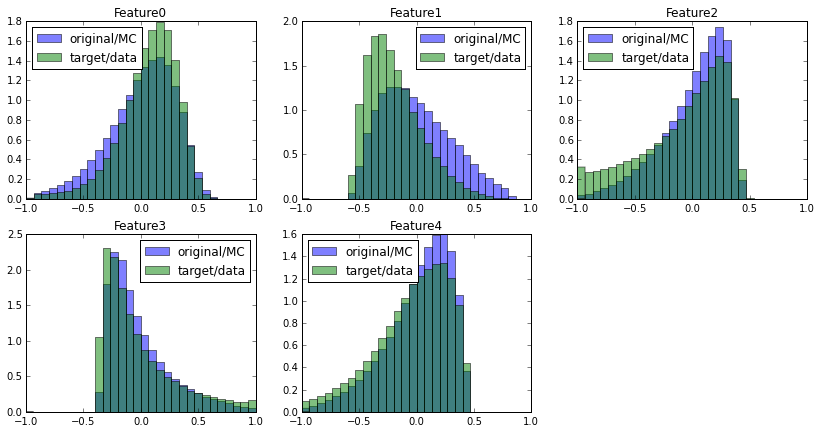

ROC AUC 0.733335473313


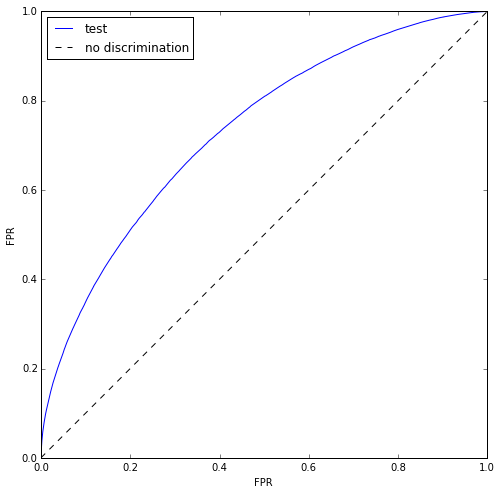

In [9]:
# for comparison: no reweighting
check_discrimination(numpy.ones(len(test_original)))

## Reweighting with bins

We train a reweighitng rule on the part of data and then check it with other part (cross-validation!).

In [11]:
feature = 'Feature0'
origin_counts, bin_limits = numpy.histogram(train_original[feature], bins=10, range=[-1,1])
target_counts, _ = numpy.histogram(train_target[feature], bins=bin_limits)
# computing ratio in each bin
counts_ratio = target_counts * 1. /  origin_counts
# computing bin index for each sample
bin_indices = numpy.searchsorted(bin_limits[1:], test_original[feature])
# taking new weights from original weights
new_test_original_weights = counts_ratio[bin_indices]

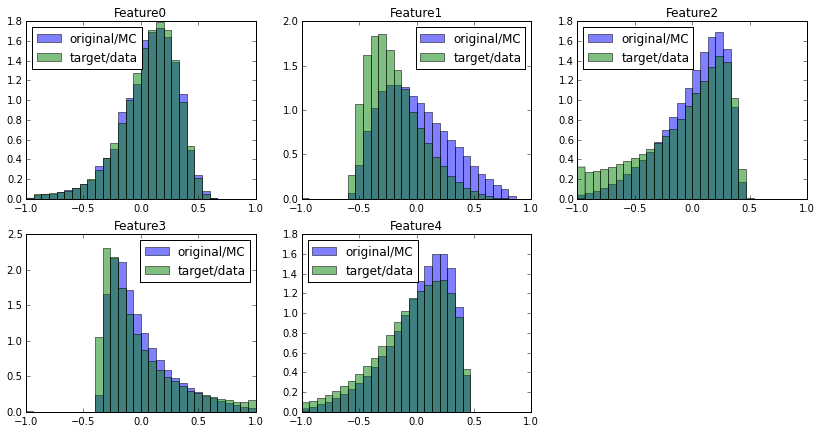

ROC AUC 0.723155639634


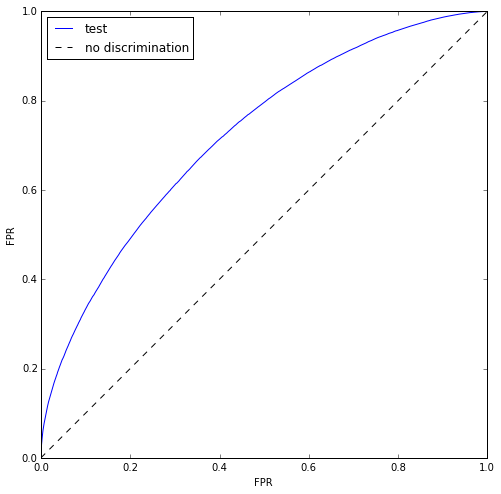

In [12]:
check_discrimination(new_test_original_weights)

## Reweighting with BDT

In [19]:
from hep_ml.reweight import GBReweighter
reweighter = GBReweighter(n_estimators=10, max_depth=6, learning_rate=0.4, min_samples_leaf= 200)
reweighter.fit(train_original, train_target)
new_bdt_test_original_weights = reweighter.predict_weights(test_original)

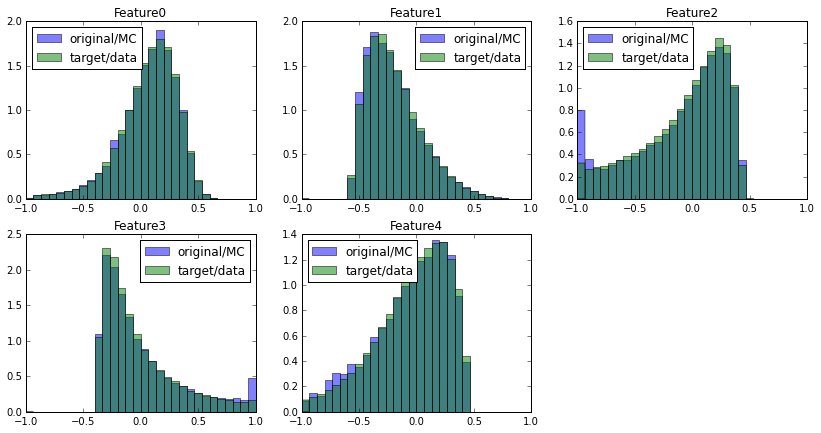

ROC AUC 0.514574408672


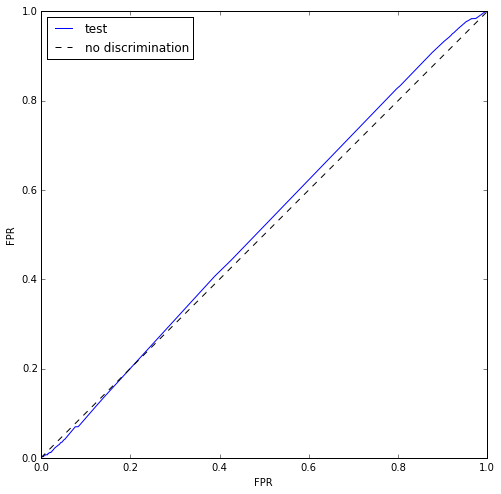

In [20]:
check_discrimination(new_bdt_test_original_weights)

To obtain the best reweighting rule we need to **minimize** the ROC AUC between reweighted original sample and target sample.


**Exercise #1.** Reweight distribution using bins. Find an optimal feature for reweighting and optimal number of bins. Use the code given above. Optionally, you can try n-dimensional reweighting with bins (use `numpy.histogram2d` or `numpy.histogramdd`). You can use `numpy.percentile` to construct percentile bin for a variable.

In [1]:
feature = 'Feature0'
origin_counts, bin_limits = numpy.histogram(train_original[feature],
                                         bins=numpy.percentile(train_original[feature], [0, 30, 50, 70, 100]), range=[-1,1])
print bin_limits
target_counts, _ = numpy.histogram(train_target[feature], bins=bin_limits)
# computing ratio in each bin
counts_ratio = target_counts * 1. /  origin_counts
# computing bin index for each sample
bin_indices = numpy.searchsorted(bin_limits[1:], test_original[feature])
# taking new weights from original weights
new_test_original_weights = counts_ratio[bin_indices]

NameError: name 'numpy' is not defined

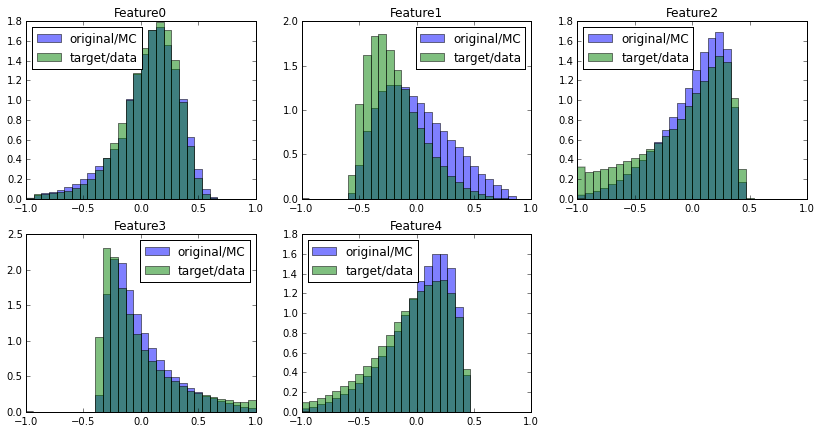

ROC AUC 0.724617641983


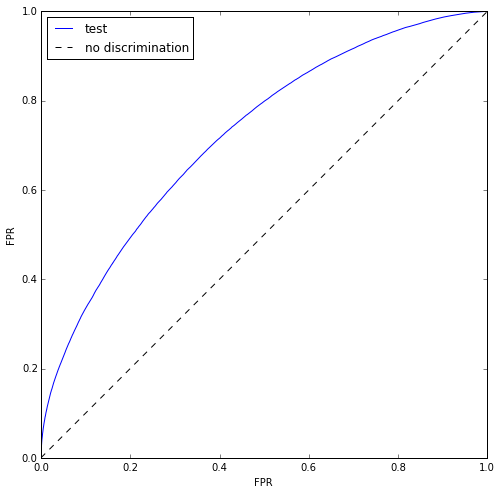

In [35]:
check_discrimination(new_test_original_weights)

**Exercise #2.** Reweight distribution using BDT. Tune max_depth, n_estimators and maybe other parameters to achieve good reweighting rule. Use the code given above.

Compare results obtained from the both exercises.